<a href="https://colab.research.google.com/github/dieineb/CNN-Brain-Tumor/blob/main/CNN_BrainTumor_WithDataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**@Dieine Bernieri Schiavon<p>
UFCSPA - Universidade Federal de Ciências da Saúde de Porto Alegre<p>
Informática Biomédica <p>
dieineb@ufcspa.edu.br** <p>
https://github.com/dieineb <p>
**16/09/2022**

# Treinando uma Rede Neural Convolucional em um pequeno conjunto de dados
Serão usadas 2.100 imagens para treinamento, 600 para validação e 300 para teste. Foi usada uma amostra balanceada, pois temos o mesmo número de amostras de imagens com tumor e sem tumor cerebral.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras as ke
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import os, shutil, pathlib

# Baixando os dados
Dataset Br35H - Kaggle
  
 

In [ ]:
original_dir = pathlib.Path ('/content/gdrive/MyDrive/Model/Kaggle_Original_Br35H') # Caminho para o diretório onde o conjunto de dados original foi descompactado
new_base_dir = pathlib.Path('/content/gdrive/MyDrive/Model/newdataBr35H') # Diretório em que será armazenado o conjunto de dados dividido em treino/validação e teste

def make_subset(subset_name, start_index, end_index): 
 for category in ("y", "no"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}{i}.jpg"

               for i in range(start_index, end_index)]
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1050) #Cria  o subconjunto de treinamento onde serão armazenadas as primeiras 1050 imagens de cada categoria
make_subset("validation", start_index=1050, end_index=1350) # Cria o subconjuto validação com as próximas 300 imagens de cada categoria
make_subset("test", start_index=1350, end_index=1500) # Cria o subconjunto teste com as próximas 150 imagens de cada categoria

# Construindo o modelo

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(180, 180, 3)) # Input imagem RGB (Red, Gree, and Blue) =  3 canais - size 180 x 180 
x = layers.Rescaling(1./255)(inputs) # Normalização  Re-escala entradas para o intervalo [0, 1] dividindo por 255

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Classificação binária 1 única saída
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary() # Verifica a arquitetura da rede

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

# Configurando o modelo para treinamento

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer="adam",  # Por default learning_rate = 0.001
 metrics=["accuracy"])

# Pré-processamento dos dados

Os dados devem ser formatados em tensores de ponto flutuante pré-processados ​​adequadamente antes de serem alimentados no modelo. Atualmente, os dados ficam em uma unidade como Arquivos JPEG, portanto, as etapas para colocá-lo no modelo são aproximadamente as seguintes:<p>
1 Leia os arquivos de imagem.<p>
2 Decodifique o conteúdo JPEG em grades RGB de pixels.<p>
3 Converta-os em tensores de ponto flutuante.<p>
4 Redimensione-os para um tamanho único para todas as imagens (usaremos 180 × 180).<p>
5 Embale-os em lotes (batches) (usaremos batches de 32 imagens).<p>

O Keras tem utilitários para cuidar dessas etapas
automaticamente. Em particular, Keras apresenta a função utilitária image_dataset_from_directory(), que permite configurar rapidamente um pipeline de dados que pode transformar automaticamente
arquivos de imagem no disco em lotes de tensores pré-processados. <p>

Chamar image_dataset_from_directory(directory) primeiro listará os subdiretórios do diretório e assumirá que cada um contém imagens de uma de nossas classes. Em seguida os arquivos de imagem serão indexados em cada subdiretório.<p>
Por fim, ele criará e retornará um tf.data.Dataset configurado para ler esses arquivos, embaralhá-los, decodificá-los para tensores, redimensioná-los para um tamanho compartilhado (180 x 180) e empacotados em lotes.

# Usando image_dataset_from_directory para ler imagens

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=32)

Found 2100 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


# Exibindo as formas dos dados e rótulos gerados pelo conjunto de dados

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Treinando o modelo usando um conjunto de dados

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="cnn_Tumor_Cerebral.keras",
 save_best_only=True,
 monitor="val_loss")
]

history = model.fit(
 train_dataset,
 epochs=20,
 validation_data=validation_dataset, 
 callbacks=callbacks)


Epoch 1/20
66/66 [==============================] - 156s 2s/step - loss: 0.4660 - accuracy: 0.7781 - val_loss: 0.4499 - val_accuracy: 0.7767
Epoch 2/20
66/66 [==============================] - 159s 2s/step - loss: 0.3029 - accuracy: 0.8705 - val_loss: 0.5360 - val_accuracy: 0.8200
Epoch 3/20
66/66 [==============================] - 175s 3s/step - loss: 0.1962 - accuracy: 0.9267 - val_loss: 0.2304 - val_accuracy: 0.9133
Epoch 4/20
66/66 [==============================] - 152s 2s/step - loss: 0.0973 - accuracy: 0.9633 - val_loss: 0.2950 - val_accuracy: 0.9167
Epoch 5/20
66/66 [==============================] - 151s 2s/step - loss: 0.0436 - accuracy: 0.9867 - val_loss: 0.3263 - val_accuracy: 0.9300
Epoch 6/20
66/66 [==============================] - 151s 2s/step - loss: 0.0659 - accuracy: 0.9767 - val_loss: 0.3405 - val_accuracy: 0.9333
Epoch 7/20
66/66 [==============================] - 152s 2s/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.3996 - val_accuracy: 0.9333
Epoch 8/20
66

# Plotando os resultados

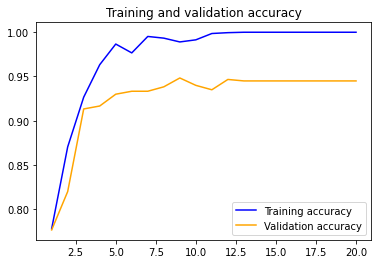

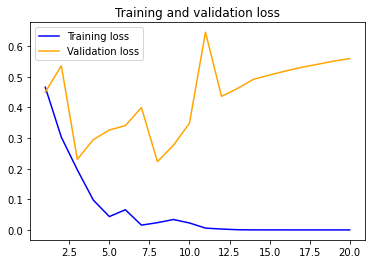

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "blue", label="Training accuracy")
plt.plot(epochs, val_accuracy, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Análise dos resultados
Os gráficos são característicos de overfitting. A precisão do treinamento aumenta linearmente ao longo do tempo, até atingir 100% na 13ª época, enquanto a precisão da validação atinge um pico de 72%.<p>
A perda de validação atinge seu mínimo após apenas 8 épocas, enquanto a perda de treinamento continua diminuindo linearmente à medida que o treinamento prossegue.<p>


In [ ]:
test_model = keras.models.load_model("cnn_Tumor_Cerebral.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 6s 510ms/step - loss: 0.5379 - accuracy: 0.8733
Test accuracy: 0.873


Obtivemos uma acurácia de 87%. (Devido à aleatoriedade das inicializações da rede neural)<p>
Como temos relativamente poucas amostras de treinamento (2.100), o overfitting será a preocupação número um.<p>
Uma série de técnicas que podem ajudar a mitigar o overfitting, como dropout por exemplo.<p>
Agora será trabalhada uma nova técnica, específica para visão computacional e usado quase universalmente ao processar imagens com modelos de aprendizado profundo: o **data augmentation ou seja, aumento de dados.**

# Usando data augmentation

O overfitting é causado por ter muito poucas amostras para aprender, tornando difícil para treinar um modelo que possa generalizar para novos dados.<p>
O aumento de dados adota a abordagem de gerar mais dados de treinamento
de amostras de treinamento existentes, aumentando as amostras por meio de um número de transformações que produzem imagens de aparência crível. O objetivo é que, na hora do treino, o modelo nunca verá exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo para mais aspectos dos dados para que possa generalizar melhor.<p>
No Keras, isso pode ser feito adicionando várias camadas de aumento de dados na
início do seu modelo. Vamos começar com um exemplo: o seguinte modelo Sequencial
encadeia várias transformações de imagem aleatórias. Em nosso modelo, incluiríamos antes da **Rescaling layer** lá nas camadas da Rede Neural Convolucional.

#Data augmentation para adicionar mais imagens ao modelo

In [ ]:
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

Essas são apenas algumas das camadas disponíveis (para saber mais, consulte a documentação do Keras).

**RandomFlip("horizontal")** — Aplica inversão horizontal a 50%
as imagens que passam por ela<p>
**RandomRotation(0.1)** — Gira as imagens de entrada por um valor aleatório no intervalo[–10%, +10%] (estas são frações de um círculo completo - em graus, o intervalo seria [–36 graus, +36 graus])<p>
**RandomZoom(0.2)**—Aproxima ou diminui a imagem por um fator aleatório no
intervalo [-20%, +20%]


# Exibindo algumas imagens de treinamento aumentadas (data augmentation)

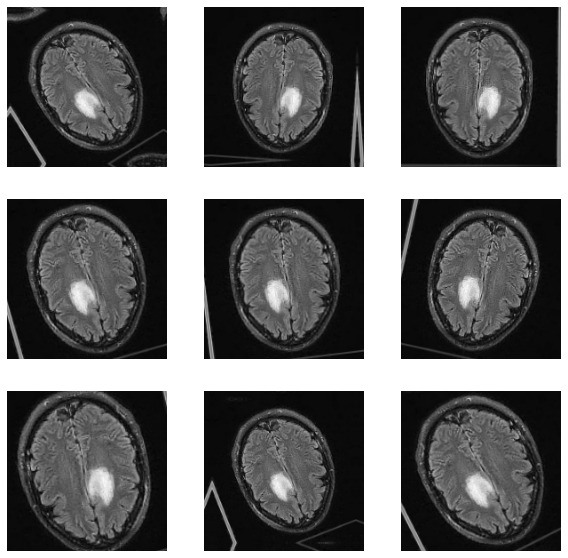

In [ ]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1): 
 for i in range(9):
     augmented_images = data_augmentation(images) # Aplica o estágio de aumento de dados ao lote de imagens
     ax = plt.subplot(3, 3, i + 1) #Plot das imagens (3 linhas por 3 colunas)
     plt.imshow(augmented_images[0].numpy().astype("uint8"))  # Exibe a primeira imagem no lote de saída. Para cada uma das nove iterações, este é um aumento da mesma imagem
     plt.axis("off")

Se treinarmos um novo modelo usando essa configuração de aumento de dados, o modelo nunca ver a mesma entrada duas vezes. Mas as entradas que ele vê ainda estão fortemente correlacionadas porque eles vêm de um pequeno número de imagens originais - não podemos produzir novas em formação; só podemos remixar informações existentes. Como tal, isso pode não ser suficiente para se livrar completamente do overfitting. Para combater ainda mais o overfitting, também adicionaremos uma camada Dropout  ao  modelo logo antes do classificador densamente conectado.<p>
Um detalhe a saber sobre camadas de aumento de imagem aleatória:<p>
Apenas como Dropout, eles ficam inativos durante a inferência (quando chamamos predict() ou evaluate().<p>
Durante a avaliação, o modelo se comportará da mesma forma que quando não incluía aumento de dados.

# Definindo novo modelo com dropout e data augmentation

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])

model.summary() # Verifica a arquitetura da rede

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

Vamos treinar o modelo usando data augmentation e dropout. Como esperamos que o ajuste excessivo (overfitting) ocorra muito mais tarde durante o treinamento, treinaremos mais épocas - ou seja 60 épocas

# Novo treino

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="cnn_Tumor_Cerebral_with_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_dataset,
 epochs=60,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/60
66/66 [==============================] - 162s 2s/step - loss: 0.6054 - accuracy: 0.6629 - val_loss: 0.5397 - val_accuracy: 0.7483
Epoch 2/60
66/66 [==============================] - 160s 2s/step - loss: 0.5256 - accuracy: 0.7471 - val_loss: 0.4965 - val_accuracy: 0.7767
Epoch 3/60
66/66 [==============================] - 161s 2s/step - loss: 0.4803 - accuracy: 0.7648 - val_loss: 1.5208 - val_accuracy: 0.6150
Epoch 4/60
66/66 [==============================] - 161s 2s/step - loss: 0.4532 - accuracy: 0.7933 - val_loss: 0.5592 - val_accuracy: 0.7083
Epoch 5/60
66/66 [==============================] - 160s 2s/step - loss: 0.4367 - accuracy: 0.8086 - val_loss: 0.5032 - val_accuracy: 0.7783
Epoch 6/60
66/66 [==============================] - 160s 2s/step - loss: 0.3945 - accuracy: 0.8286 - val_loss: 0.4379 - val_accuracy: 0.8050
Epoch 7/60
66/66 [==============================] - 159s 2s/step - loss: 0.3633 - accuracy: 0.8529 - val_loss: 0.4252 - val_accuracy: 0.7933
Epoch 8/60
66

# Plotar os resultados novamente

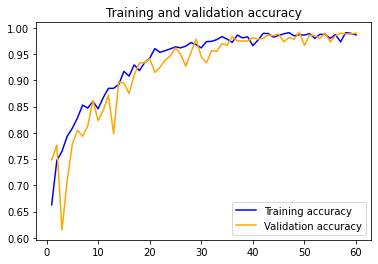

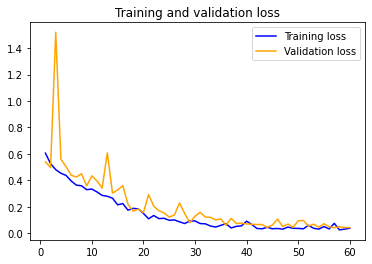

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "blue", label="Training accuracy")
plt.plot(epochs, val_accuracy, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Graças ao aumento de dados e dropout, conseguimos observar nos gráficos curvas bem mais consistentes tanto no treino quanto na validação. A acurácia da validação termina consistentemente na faixa de 98 - 99%— uma grande melhoria em relação à primeira tentativa

# Avaliando o modelo no conjunto de teste (imagens novas nunca "vistas" pelo modelo)

In [ ]:
test_model = keras.models.load_model(
 "cnn_Tumor_Cerebral_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 6s 509ms/step - loss: 0.4337 - accuracy: 0.9100
Test accuracy: 0.910


Foi obtida uma acurácia de teste de 91 %.<p>
Ao ajustar ainda mais a configuração do modelo (como o número de filtros por
camada de convolução, ou o número de camadas no modelo), podemos obter uma
acurácia ainda melhor. Mas seria difícil ir mais alto
apenas treinando o modelo  do zero, porque temos tão poucos dados para trabalhar. Como próximo passo para melhorar a precisão neste problema, será usado um modelo pré-treinado a **VGG16**.

**Referências:**<p>

Livro: Deep Learning With Python [François Chollet, 2021] - Segunda edição<p>

Capítulo 5 - Fundamentals of machine learning<p>

Capítulo 8 - Introduction to Deep Learning for computer vision<p>

Dataset: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection